In [1]:
%run imports.py

/home/ayush/miniconda3/envs/scan/lib/python3.8/site-packages/pymatgen/ext/matproj.py:454: DeprecationWarning:

__init__ is deprecated
MaterialsProjectCompatibility will be updated with new correction classes as well as new values of corrections and uncertainties in 2020



Imports successfully loaded


In [2]:
masks = loadfn('masks.json')
elfcars = loadfn('elfcars.json')

In [3]:
for e in elfcars.keys():
    print(elfcars[e].data['total'].shape, masks[e].data['total'].shape)

(24, 24, 24) (48, 48, 48)
(28, 28, 28) (56, 56, 56)
(60, 60, 60) (120, 120, 120)
(24, 24, 64) (48, 48, 128)
(24, 24, 40) (48, 48, 80)
(40, 40, 80) (80, 80, 160)
(42, 42, 48) (84, 84, 96)
(32, 32, 36) (64, 64, 72)
(28, 28, 30) (56, 56, 60)
(40, 48, 64) (80, 96, 128)
(28, 28, 48) (56, 56, 96)
(48, 48, 48) (96, 96, 96)
(48, 48, 48) (96, 96, 96)
(30, 30, 30) (60, 60, 60)
(36, 36, 54) (72, 72, 108)
(48, 50, 60) (96, 100, 120)
(28, 28, 28) (56, 56, 56)
(36, 36, 36) (72, 72, 72)
(28, 40, 54) (56, 80, 108)
(54, 54, 60) (108, 108, 120)
(28, 28, 28) (56, 56, 56)
(36, 36, 40) (72, 72, 80)
(28, 28, 28) (56, 56, 56)
(30, 30, 30) (60, 60, 60)
(36, 36, 36) (72, 72, 72)
(36, 36, 36) (72, 72, 72)
(32, 32, 54) (64, 64, 108)
(24, 42, 60) (48, 84, 120)
(48, 54, 64) (96, 108, 128)
(48, 48, 48) (96, 96, 96)
(28, 28, 54) (56, 56, 108)
(70, 70, 70) (140, 140, 140)
(28, 48, 28) (56, 96, 56)
(36, 36, 36) (72, 72, 72)
(36, 36, 56) (72, 72, 112)
(70, 70, 98) (140, 140, 196)
(32, 32, 48) (64, 64, 96)
(30, 40, 48) 

In [4]:
ids = [i for i in masks.keys()]
print(ids)

['6405', '3890', '7373', '11133', '3914', '5804', '10090', '3957', '3996', '6135', '3955', '4648', '4827', '3901', '2779', '6017', '4392', '3992', '4837', '6454', '4601', '4826', '3929', '3926', '3930', '4019', '6412', '5874', '6240', '5312', '2936', '10792', '4617', '4102', '4782', '8414', '5364', '4870', '7394', '10278', '10118', '4406', '6359', '4026', '10408', '9789', '9416', '2180', '4999', '4510', '3947', '4072', '2072', '9887', '10201', '2597', '3882', '4212', '4226', '4682', '9493', '7850', '9879', '8450', '8661', '4331', '4687', '5723', '10375', '8706', '10389', '5431', '7076', '7562', '10285', '7722', '5662', '4089', '9731', '4656', '9068', '8428', '9914', '6190', '7962', '10642', '5462', '4611', '4035', '7921', '7740', '6344', '5557', '5570', '6853', '6417', '4283', '4311', '5692', '4252', '3942', '3989', '9927', '8986', '4758', '2167', '4787', '2820', '7468', '8989', '10948', '6283', '7408', '11087', '6862', '4757', '6094', '2085', '4079', '4346', '7239', '5863', '6872', '4

In [5]:
def create_mask(mask, index):
    shape = mask.shape
    flat = mask.flatten()
    for i in range(len(flat)):
        flat[i] = 1 if int(flat[i]) == index else 0
    mask = flat.reshape(shape)
    return mask

def apply_mask(elfcar, mask):
    ex, ey, ez = elfcar.shape
    mx, my, mz = mask.shape
    masked = []
    for i1 in range(len(elfcar)):
        xfac = int(mx / ex)
        for i2 in range(len(elfcar[i1])):
            yfac = int(my / ey)
            for i3 in range(len(elfcar[i1][i2])):
                zfac = int(mz / ez)
                masked.append(elfcar[i1][i2][i3] * mask[i1 * xfac][i2 * yfac][i3 * zfac])
    return np.array(masked)

def strip_zeros(arr):
    return np.array([a for a in arr if a != 0])

In [13]:
def feature_vector(i, num_wells=15):
    elfcar_data, mask_data = elfcars[i].get_alpha().data['total'], masks[i].data['total']
    vector = []
    for index in range(1, int(max(mask_data.flatten())) + 1):        
        clean_mask = strip_zeros(apply_mask(elfcar_data, create_mask(mask_data, index)))
        mean, stddev, maxv = np.mean(clean_mask), np.std(clean_mask), np.max(clean_mask)
        maxv = maxv / mean ** 2
        vector.append([mean, stddev, maxv])
    vector = sorted(vector, key=lambda e: e[0])
    ndescriptors = len(vector[0])
    length = num_wells * ndescriptors
    vector = [y for x in vector for y in x]
    if len(vector) > length:
        vector = vector[:length]
    elif len(vector) < length:
        idx = 0
        while len(vector) < length:
            vector += vector[idx:idx+ndescriptors]
            idx += ndescriptors
    return np.array(vector)

In [5]:
nwells = []
for i in ids:
    mask_data = masks[i].data['total']
    nwells.append(int(max(mask_data.flatten())))

In [11]:
feature_vector('7178')

array([3.36346231, 3.20716914, 1.42338915, 3.36446139, 3.23528971,
       1.42517169])

In [14]:
vector_list = []
for i in tqdm(ids):
    new_vec = feature_vector(i)
    vector_list.append(new_vec)


100%|██████████| 160/160 [3:17:06<00:00, 73.92s/it]


In [15]:
A = np.vstack(vector_list)

In [16]:
A.shape

(160, 45)

In [17]:
error_data = pd.read_json(loadfn('data/error_data.json'), orient='columns')
error_data

,Formula,Experimental,Computed,Error
0,HgS,-0.552332,-2.147391e-01,3.375925e-01
1,Li2Se,-4.353368,-4.212850e+00,1.405180e-01
2,CoSO4,-9.205181,-8.707624e+00,4.975578e-01
3,Bi,0.000000,0.000000e+00,0.000000e+00
4,TaSi2,-1.235233,-1.259144e+00,-2.391124e-02
...,...,...,...,...
732,YH3,-2.753368,-2.906811e+00,-1.534435e-01
733,UB2,-1.530570,-1.550134e+00,-1.956439e-02
734,LaN,-3.100518,-3.130231e+00,-2.971281e-02
735,USe,-2.856995,-1.637004e+00,1.219991e+00


In [18]:
exp = error_data.Formula.tolist()

In [19]:
'NaBr' in exp

True

In [20]:
b, drops = [], []
for x in range(len(ids)):
    i = ids[x]
    found = False
    f = elfcars[i].structure.composition.reduced_formula
    if f in exp:
        for j in range(len(error_data)):
            row = error_data.iloc[j]
            if f == row['Formula']:
                b.append(row['Error'] / row['Experimental'])
    else:
        drops.append(x)
drops

[20,
 30,
 61,
 62,
 63,
 64,
 67,
 69,
 71,
 82,
 89,
 90,
 91,
 109,
 116,
 128,
 145,
 146,
 148]

In [21]:
A = np.vstack(vector_list)
A.shape

(160, 45)

In [22]:
A = np.delete(A, drops, axis=0)
A.shape

(141, 45)

In [23]:
A_train, A_test = A[:130], A[130:]
b_train, b_test = b[:130], b[130:]

In [24]:
x_hat = np.linalg.inv(A_train.T @ A_train) @ A_train.T @ b_train

In [25]:
x_hat

array([ 1.08358600e-01, -1.13737055e-01, -2.71838242e-03, -1.21934215e-01,
        1.00530977e-01,  4.64581079e-03,  1.05412810e-01, -5.48048020e-02,
        5.74204458e-03, -5.00372748e-02,  2.40376654e-02,  6.48469954e-04,
       -3.27378836e-01,  7.66862384e-02, -1.50322984e-03,  3.29237957e-01,
       -6.81425552e-02, -5.27772005e-04, -3.10816151e-01,  6.32818459e-02,
        1.24782126e-03,  3.22266996e-01, -4.55495911e-02, -4.55430186e-03,
       -8.11935103e-02,  5.38499915e-02, -5.70687590e-03,  3.92962836e-02,
       -2.39050491e-02, -9.44870064e-04,  3.52582537e-01, -7.69568657e-02,
        1.37589536e-03, -3.47888156e-01,  6.83284946e-02,  7.72399542e-04,
        1.91281263e-01,  6.51533603e-02, -2.21863111e-03, -1.69840831e-01,
       -5.53091927e-02,  4.06698342e-05, -6.25987509e-02,  1.38051945e-03,
       -6.34140197e-04])

In [26]:
A[0]

array([2.43177303, 2.16549516, 1.63531506, 7.86499098, 4.16637607,
       0.23584673, 2.43177303, 2.16549516, 1.63531506, 7.86499098,
       4.16637607, 0.23584673, 2.43177303, 2.16549516, 1.63531506,
       7.86499098, 4.16637607, 0.23584673, 2.43177303, 2.16549516,
       1.63531506, 7.86499098, 4.16637607, 0.23584673, 2.43177303,
       2.16549516, 1.63531506, 7.86499098, 4.16637607, 0.23584673,
       2.43177303, 2.16549516, 1.63531506, 7.86499098, 4.16637607,
       0.23584673, 2.43177303, 2.16549516, 1.63531506, 7.86499098,
       4.16637607, 0.23584673, 2.43177303, 2.16549516, 1.63531506])

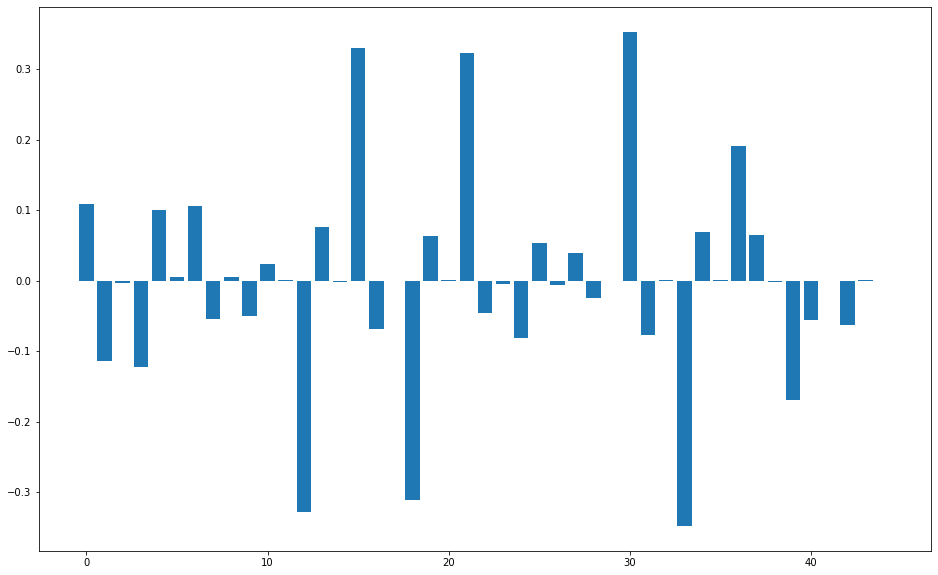

In [27]:
plt.figure(figsize=(16,10))
plt.bar(x=[i for i in range(45)], height=x_hat)
plt.show()

In [28]:
result = A_test @ x_hat
for i in range(len(result)):
    print(result[i], '\t', b_test[i])

-0.12272868577010604 	 -0.0432668590247657
0.03728223814212556 	 -0.0792461021764647
0.044950378673297195 	 0.04772217124716452
-0.38628497578868576 	 -0.01251329673282663
-0.018871750564487783 	 0.02814525524853178
-0.06748398894154393 	 0.03682133373718627
-0.07347053998301131 	 -0.030642429494516538
-0.05596810713687712 	 -0.05287007630079422
-1.554368150647233 	 -0.08149546474387778
0.030806666317613914 	 -0.01837328164108803
-0.011321912019281353 	 -0.03609441522734562


In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
model = LinearRegression()

In [31]:
reg = model.fit(A_train, b_train)

In [32]:
reg.coef_

array([-0.1038013 , -0.04611826, -0.02032873,  0.09770624,  0.02972808,
        0.02287195,  0.10935794, -0.044568  ,  0.00445373, -0.05797741,
        0.01822815,  0.00099978, -0.27075966,  0.08155648, -0.0055501 ,
        0.26320663, -0.07122758,  0.00317823, -0.2395092 ,  0.05309837,
        0.00258406,  0.2583894 , -0.03838887, -0.00518621, -0.07676843,
        0.04345864, -0.00435687,  0.04116342, -0.0180416 , -0.00122957,
        0.29275433, -0.0817944 ,  0.00542664, -0.27956418,  0.07139225,
       -0.00291887,  0.35575103,  0.00077363,  0.01563832, -0.3217346 ,
        0.00829993, -0.01753198, -0.07030161,  0.00152869, -0.00070135])

In [34]:
result2 = A_test @ reg.coef_
for i in range(len(result2)):
    print(result2[i], '\t', b_test[i])

-0.05595755193561511 	 -0.0432668590247657
0.09531956102084249 	 -0.0792461021764647
0.08517357499934905 	 0.04772217124716452
-0.35566442177443736 	 -0.01251329673282663
0.004152361671241967 	 0.02814525524853178
0.01919242019423427 	 0.03682133373718627
0.013601576212001785 	 -0.030642429494516538
0.08780254149508507 	 -0.05287007630079422
-1.9708090146326038 	 -0.08149546474387778
0.12482623642235963 	 -0.01837328164108803
0.05571004498438511 	 -0.03609441522734562


In [35]:
np.save('A.npy', A)
np.save('b.npy', b)

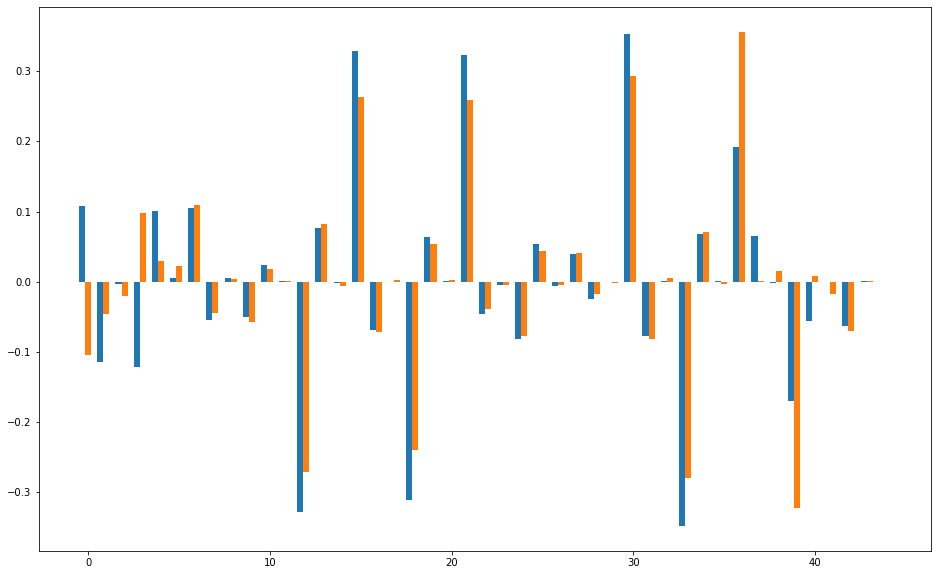

In [33]:
plt.figure(figsize=(16,10))
indices = [i for i in range(45)]
#Calculate optimal width
width = np.min(np.diff(indices))/3

plt.bar(indices-width,x_hat,width)
plt.bar(indices,reg.coef_,width)
plt.show()

In [157]:
working_dir = os.getcwd()
working_dir

'/mnt/c/Users/Ayush/Desktop/scan-error-analysis'

In [159]:
calc_path = os.path.join(working_dir, 'CALCS/')
calc_path

'/mnt/c/Users/Ayush/Desktop/scan-error-analysis/CALCS/'

In [160]:
os.chdir(calc_path)
os.getcwd()

'/mnt/c/Users/Ayush/Desktop/scan-error-analysis/CALCS'

In [161]:
subprocess.run(['touch', 'test.py'])

CompletedProcess(args=['touch', 'test.py'], returncode=0)

In [162]:
subprocess.run(['touch', 'test2.py'])

CompletedProcess(args=['touch', 'test2.py'], returncode=0)

In [166]:
subprocess.run(['rm', '-rf', '/*'])

CompletedProcess(args=['rm', '-rf', '/*'], returncode=0)

In [167]:
subprocess.run(['touch', 'test.py'])

CompletedProcess(args=['touch', 'test.py'], returncode=0)

In [170]:
elfcars['8706'].write_file('CHGCAR')

In [173]:
subprocess.run(['bader', 'CHGCAR'])

CompletedProcess(args=['bader', 'CHGCAR'], returncode=0)

In [172]:
elfcars['4102'].write_file('CHGCAR')